<a href="https://colab.research.google.com/github/reinaldohaas/QCD/blob/main/QCD_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial Atualizado: Análise de Qualidade com Arquivos CSV + DQC

Este notebook foi reestruturado para analisar dados do projeto SONDA que são fornecidos em um novo formato: um arquivo `.csv` para os dados e um arquivo `_DQC.csv` para os flags de qualidade.

**Principais Mudanças no Fluxo de Trabalho:**
1.  **Leitura de CSVs:** O código agora lê arquivos delimitados por ponto e vírgula.
2.  **Merge de Dados:** Os dados meteorológicos e os dados de qualidade são unidos em um único DataFrame.
3.  **Processamento de Flags:** Os flags de 3 dígitos (ex: `529`) são processados para extrair o dígito final, que representa o status consolidado da qualidade (ex: `9`).

## Passo 1: Preparação do Ambiente

In [ ]:
# Importando as bibliotecas essenciais
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


## Passo 2: Aquisição e Extração dos Dados do Arquivo `.7z`

In [ ]:
# --- Passo 2.1: Instalar o descompactador p7zip ---
print("Instalando o p7zip-full...")
!apt-get install -y p7zip-full -qq

# --- Passo 2.2: Baixar o arquivo .7z ---
url = 'https://sonda.ccst.inpe.br/basedados/dados/sonda/ambientais/SMS/2019/SMS1904ED.7z'
archive_filename = url.split('/')[-1]
print(f"Baixando o arquivo {archive_filename}...")
!wget -q -O {archive_filename} {url}

# --- Passo 2.3: Extrair o conteúdo do arquivo ---
print(f"Extraindo conteúdo de {archive_filename}...")
!7z x {archive_filename} -o.

print("\nExtração concluída. Arquivos CSV estão prontos para serem lidos.")

Instalando o p7zip-full...
Baixando o arquivo SMS1904ED.7z...
Extraindo conteúdo de SMS1904ED.7z...

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 433684 bytes (424 KiB)

Extracting archive: SMS1904ED.7z
--
Path = SMS1904ED.7z
Type = 7z
Physical Size = 433684
Headers Size = 188
Method = LZMA2:6m
Solid = +
Blocks = 1

  0%    Everything is Ok

Files: 2
Size:       6044060
Compressed: 433684

Extração concluída. Arquivos CSV estão prontos para serem lidos.


In [15]:
# --- Listar e mostrar o conteúdo dos arquivos CSV ---
print("\nConteúdo dos arquivos CSV extraídos:")

# Use glob to find all CSV files
csv_files = glob.glob('*.csv')

if not csv_files:
    print("Nenhum arquivo CSV encontrado.")
else:
    for csv_file in csv_files:
        print(f"\n--- Conteúdo de {csv_file} (Primeiras 5 linhas) ---")
        try:
            # Read the first 5 lines to display
            with open(csv_file, 'r') as f:
                for i in range(5):
                    line = f.readline()
                    if not line:
                        break
                    print(line.strip())
        except Exception as e:
            print(f"Erro ao ler o arquivo {csv_file}: {e}")


Conteúdo dos arquivos CSV extraídos:

--- Conteúdo de SMS1904ED_DQC.csv (Primeiras 5 linhas) ---
08;2019;91;0;599;999;599;599;599;599;552;009;099;999;552;552
08;2019;91;1;599;999;599;599;599;599;552;009;099;999;552;552
08;2019;91;2;599;999;599;599;599;599;552;009;099;999;552;552
08;2019;91;3;599;999;599;599;599;599;552;009;099;999;552;552
08;2019;91;4;599;999;599;599;599;599;552;009;099;999;552;552

--- Conteúdo de SMS1904ED.csv (Primeiras 5 linhas) ---
08;2019;91;0;-1.469;0.630;-0.917;126.3;-0.139;-0.002;-49.39; 0.92;961.06;0;0;0
08;2019;91;1;-1.407;0.630;-0.914;120.8;-0.129;0;-49.39; 0.92;961.12;0;0;0
08;2019;91;2;-1.407;0.630;-0.850;116.9;-0.114;0.019;-49.36; 0.92;961.19;0;0;0
08;2019;91;3;-1.402;0.630;-0.621;115.3;-0.098;0.021;-49.37; 0.89;961.19;0;0;0
08;2019;91;4;-1.266;0.630;-0.569;115.8;-0.108;0.034;-49.40; 0.92;961.31;0;0;0


## Passo 3: Carregamento, Junção e Processamento dos Dados

Esta é a etapa mais modificada. O código irá encontrar os pares de arquivos, lê-los, juntá-los e processar os flags.

In [ ]:
# --- Definição dos Nomes das Colunas (Baseado no formato fornecido) ---
# Colunas de identificação de tempo, usadas para o merge
time_cols = ['day', 'year', 'julian_day', 'hhmm']

# Colunas de dados meteorológicos (suposição baseada na ordem típica de dados SONDA)
data_cols_names = time_cols + ['glo_avg', 'dir_avg', 'dif_avg', 'lw_avg', 'par_avg', 'uv_avg', 'zenith_angle', 'ws_avg', 'press_avg', 'temp_avg', 'rh_avg', 'prec_tot']

# Colunas dos flags de qualidade (DQC) - We expect 16 columns, but the file might have more
# We'll read with a higher number of expected columns and then select the first 16
dqc_cols_names_expected = time_cols + ['glo_flg', 'dir_flg', 'dif_flg', 'lw_flg', 'par_flg', 'uv_flg', 'zenith_flg', 'ws_flg', 'press_flg', 'temp_flg', 'rh_flg', 'prec_flg']
# Let's assume the maximum number of columns seen in the error is 30
max_expected_cols = 30
dqc_temp_col_names = [f'col_{i}' for i in range(max_expected_cols)]


# --- Encontrar e Processar os Pares de Arquivos ---
data_files = sorted([f for f in glob.glob('*.csv') if not f.endswith('_DQC.csv')])

if not data_files:
    raise FileNotFoundError("Nenhum arquivo de dados (.csv) encontrado após a extração.")

print(f"Encontrados {len(data_files)} pares de arquivos de dados e DQC.")

list_of_merged_dfs = []

for data_file in data_files:
    dqc_file = data_file.replace('.csv', '_DQC.csv')
    if os.path.exists(dqc_file):
        # Ler o arquivo de dados
        df_data = pd.read_csv(data_file, sep=';', header=None, names=data_cols_names, low_memory=False)

        # Ler o arquivo de quality, expecting more columns to avoid ParserError
        df_dqc = pd.read_csv(dqc_file, sep=';', header=None, names=dqc_temp_col_names, low_memory=False)

        # Select the first expected number of DQC columns and rename them
        df_dqc = df_dqc.iloc[:, :len(dqc_cols_names_expected)]
        df_dqc.columns = dqc_cols_names_expected


        # Juntar (merge) os dois DataFrames usando as colunas de tempo como chave
        df_merged = pd.merge(df_data, df_dqc, on=time_cols)
        list_of_merged_dfs.append(df_merged)

# Concatenar todos os DataFrames diários em um único DataFrame para o mês inteiro
df = pd.concat(list_of_merged_dfs, ignore_index=True)

print(f"Todos os dados foram carregados e unidos. Total de registros: {len(df)}")
display(df.head())

Encontrados 1 pares de arquivos de dados e DQC.
Todos os dados foram carregados e unidos. Total de registros: 43198


,day,year,julian_day,hhmm,glo_avg,dir_avg,dif_avg,lw_avg,par_avg,uv_avg,...,dif_flg,lw_flg,par_flg,uv_flg,zenith_flg,ws_flg,press_flg,temp_flg,rh_flg,prec_flg
0,8,2019,91,0,-1.469,0.63,-0.917,126.3,-0.139,-0.002,...,599.0,599.0,599.0,599.0,552.0,9.0,99.0,999.0,552.0,552.0
1,8,2019,91,1,-1.407,0.63,-0.914,120.8,-0.129,0.000,...,599.0,599.0,599.0,599.0,552.0,9.0,99.0,999.0,552.0,552.0
2,8,2019,91,2,-1.407,0.63,-0.850,116.9,-0.114,0.019,...,599.0,599.0,599.0,599.0,552.0,9.0,99.0,999.0,552.0,552.0
3,8,2019,91,3,-1.402,0.63,-0.621,115.3,-0.098,0.021,...,599.0,599.0,599.0,599.0,552.0,9.0,99.0,999.0,552.0,552.0
4,8,2019,91,4,-1.266,0.63,-0.569,115.8,-0.108,0.034,...,599.0,599.0,599.0,599.0,552.0,9.0,99.0,999.0,552.0,552.0


In [ ]:
dqc_file = 'SMS1904ED_DQC.csv'
line_number_to_check = 5769

try:
    with open(dqc_file, 'r') as f:
        for i, line in enumerate(f):
            if i + 1 == line_number_to_check:
                print(f"Content of line {line_number_to_check}:")
                print(line)
                break
except FileNotFoundError:
    print(f"Error: File '{dqc_file}' not found.")
except Exception as e:
    print(f"An error occurred: {e}")

Content of line 5769:
08;2019;95;8;599;999;599;299;599;599;999;552;099;999;08;2019;95;9;999;552;599;299;599;599;999;552;099;999;552;552



## Passo 4: Pré-processamento e Limpeza

Agora, criamos o `timestamp` para o índice e processamos os flags de 3 dígitos para extrair apenas o último, que representa a qualidade final.

In [ ]:
if not df.empty:
    # --- Criação do Timestamp ---
    # Usa o ano, dia juliano e hhmm para criar o timestamp diretamente
    # Combine year, julian_day, and hhmm into a single string in 'YYYYJJJHHMM' format
    df['datetime_str'] = df['year'].astype(str) + df['julian_day'].astype(str).str.zfill(3) + df['hhmm'].astype(str).str.zfill(4)

    print("Sample of generated datetime_str:")
    display(df['datetime_str'].head())

    # Convert the combined string to datetime objects using the correct format
    # Use errors='coerce' to turn unparseable dates into NaT
    df['timestamp'] = pd.to_datetime(df['datetime_str'], format='%Y%j%H%M', errors='coerce')
    df.set_index('timestamp', inplace=True)

    # --- Seleção das Variáveis de Interesse ---
    variables_of_interest = {
        'press_avg': 'Pressão (hPa)',
        'glo_avg': 'Radiação Global (W/m²)',
        'ws_avg': 'Velocidade do Vento (m/s)',
        'temp_avg': 'Temperatura do Ar (°C)'
    }

    # --- Processamento dos Flags de 3 Dígitos ---
    print("Processando flags de 3 dígitos para extrair o status final de qualidade...")
    for var in variables_of_interest.keys():
        flag_col = var.replace('_avg', '_flg')
        if flag_col in df.columns:
            # Convert to string, take the last character, and convert back to number
            # Handle potential NaN values by converting to string first, then extracting the last char if not NaN
            df[flag_col] = df[flag_col].astype(str).str.strip().str[-1]
            # Convert to numeric, coercing errors to NaN
            df[flag_col] = pd.to_numeric(df[flag_col], errors='coerce')


    # Criar o DataFrame final para análise
    cols_to_keep = list(variables_of_interest.keys()) + [v.replace('_avg', '_flg') for v in variables_of_interest.keys()]
    # Ensure all columns exist before selecting
    cols_to_keep_existing = [col for col in cols_to_keep if col in df.columns]
    df_analysis = df[cols_to_keep_existing].copy()

    print("Pré-processamento concluído.")
    display(df_analysis.head())

Sample of generated datetime_str:


,datetime_str
0,20190910000
1,20190910001
2,20190910002
3,20190910003
4,20190910004


Processando flags de 3 dígitos para extrair o status final de qualidade...
Pré-processamento concluído.


,press_avg,glo_avg,ws_avg,temp_avg,press_flg,glo_flg,ws_flg,temp_flg
timestamp,,,,,,,,
2019-04-01 00:00:00,961.06,-1.469,0.92,0.0,0.0,0.0,0.0,0.0
2019-04-01 00:01:00,961.12,-1.407,0.92,0.0,0.0,0.0,0.0,0.0
2019-04-01 00:02:00,961.19,-1.407,0.92,0.0,0.0,0.0,0.0,0.0
2019-04-01 00:03:00,961.19,-1.402,0.89,0.0,0.0,0.0,0.0,0.0
2019-04-01 00:04:00,961.31,-1.266,0.92,0.0,0.0,0.0,0.0,0.0


## Passo 5: Verificação da Qualidade e Consistência (Análises)

Com os dados devidamente processados, as análises quantitativas e visuais podem ser executadas da mesma forma que no primeiro tutorial.

--- Análise da Distribuição dos Flags de Qualidade ---

----- Pressão (hPa) -----
press_flg
0.0    61.39 %
NaN    38.61 %
Name: proportion, dtype: object

----- Radiação Global (W/m²) -----
glo_flg
0.0    61.39 %
NaN    38.61 %
Name: proportion, dtype: object

----- Velocidade do Vento (m/s) -----
ws_flg
0.0    61.39 %
NaN    38.61 %
Name: proportion, dtype: object

----- Temperatura do Ar (°C) -----
temp_flg
0.0    61.39 %
NaN    38.61 %
Name: proportion, dtype: object

--- Tabela Resumo da Qualidade dos Dados (%) ---


,% Flag 0,NaN
Pressão (hPa),61.39,38.61
Radiação Global (W/m²),61.39,38.61
Velocidade do Vento (m/s),61.39,38.61
Temperatura do Ar (°C),61.39,38.61


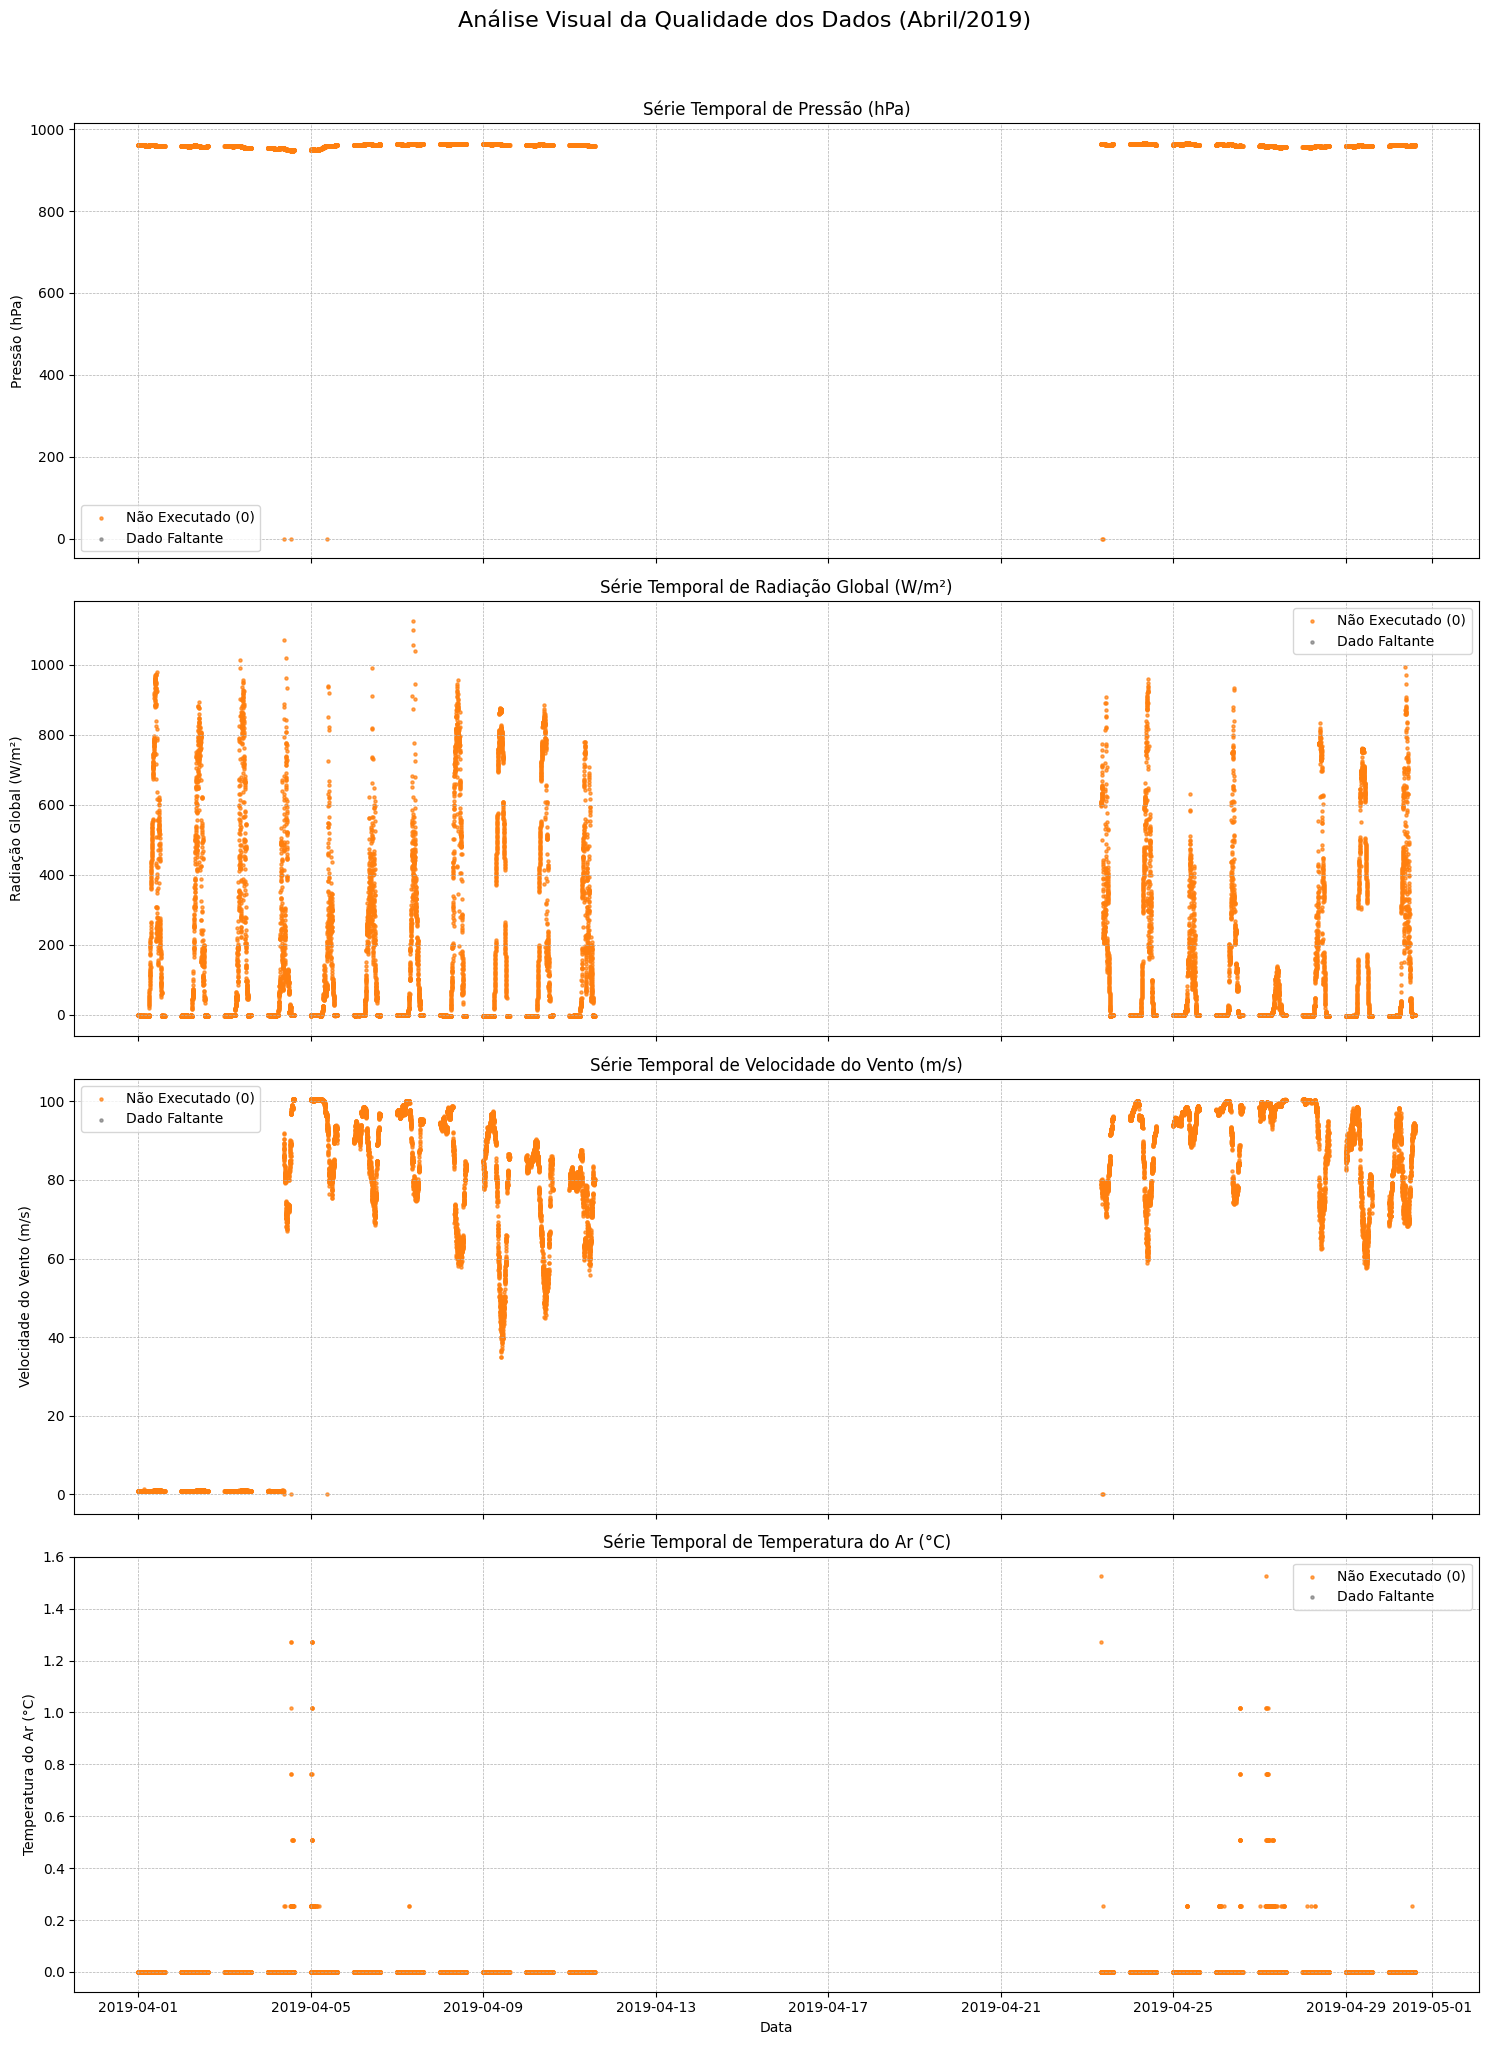

In [ ]:
import numpy as np

if 'df_analysis' in locals() and not df_analysis.empty:
    # --- 5.1 Análise Quantitativa ---
    flag_summary = {}
    print("--- Análise da Distribuição dos Flags de Qualidade ---")

    for var, description in variables_of_interest.items():
        flag_col = var.replace('_avg', '_flg')
        flag_percentages = df_analysis[flag_col].value_counts(normalize=True, dropna=False) * 100
        print(f"\n----- {description} -----")
        print(flag_percentages.round(2).astype(str) + ' %')
        flag_summary[description] = flag_percentages.round(2)

    summary_df = pd.DataFrame(flag_summary).T.fillna(0)
    # Correctly rename columns to include NaN representation if needed, or handle NaN in display
    # For display purposes, let's rename 0, 2, 5, 9 and keep NaN as is for now in the df,
    # or rename NaN to a string for better readability in the summary table.
    # Let's rename NaN to 'NaN' string for the summary table display.
    summary_df.rename(columns={0.0: '% Flag 0', 2.0: '% Flag 2 (Suspeito)', 5.0: '% Flag 5', 9.0: '% Flag 9 (Boa Qualidade)', np.nan: '% Dado Faltante'}, inplace=True)

    print("\n--- Tabela Resumo da Qualidade dos Dados (%) ---")
    display(summary_df)

    # --- 5.2 Análise Visual ---
    # Use np.nan for the key for missing data
    flag_map = {9.0: '#2ca02c', 2.0: '#d62728', 0.0: '#ff7f0e', 5.0: '#9467bd', np.nan: '#7f7f7f'}
    flag_labels = {9.0: 'Boa Qualidade (9)', 2.0: 'Suspeito (2)', 0.0: 'Não Executado (0)', 5.0: 'Não Pôde Executar (5)', np.nan: 'Dado Faltante'}

    fig, axes = plt.subplots(len(variables_of_interest), 1, figsize=(15, len(variables_of_interest) * 5), sharex=True)
    fig.suptitle('Análise Visual da Qualidade dos Dados (Abril/2019)', fontsize=16, y=1.02)

    for i, (var, description) in enumerate(variables_of_interest.items()):
        ax = axes[i]
        flag_col = var.replace('_avg', '_flg')
        # Iterate through the flag_map to ensure all defined categories are plotted
        for flag_val, color in flag_map.items():
            if pd.isna(flag_val):
                subset = df_analysis[df_analysis[flag_col].isna()]
            else:
                subset = df_analysis[df_analysis[flag_col] == flag_val]

            if not subset.empty:
                ax.scatter(subset.index, subset[var], color=color, label=flag_labels[flag_val], s=5, alpha=0.7)

        ax.set_ylabel(description)
        ax.grid(True, linestyle='--', linewidth=0.5)
        ax.legend(loc='best')
        ax.set_title(f'Série Temporal de {description}')

    plt.xlabel('Data')
    plt.tight_layout()
    plt.show()

## Passo 6: Geração do Relatório em Excel

In [ ]:
if 'df_analysis' in locals() and not df_analysis.empty:
    flag_cols = [col for col in df_analysis.columns if '_flg' in col]
    suspect_mask = (df_analysis[flag_cols] == 2).any(axis=1)
    suspect_data = df_analysis[suspect_mask]

    print(f"\nForam encontrados {len(suspect_data)} registros com pelo menos um dado suspeito (Flag 2).")

    output_filename = f'Relatorio_Qualidade_SMS_201904.xlsx'
    with pd.ExcelWriter(output_filename) as writer:
        summary_df.to_excel(writer, sheet_name='Resumo da Qualidade')
        if not suspect_data.empty:
            suspect_data.to_excel(writer, sheet_name='Dados Suspeitos (Flag 2)')

    print(f"Relatório salvo como '{output_filename}'. Baixe-o no painel de arquivos à esquerda.")


Foram encontrados 0 registros com pelo menos um dado suspeito (Flag 2).
Relatório salvo como 'Relatorio_Qualidade_SMS_201904.xlsx'. Baixe-o no painel de arquivos à esquerda.
